In [2]:
# custom class om DataLoader te kunnen gebruiken

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import os
from dotenv import load_dotenv

# load_dotenv()
# load_dotenv(dotenv_path="C:/Users/peta GamePC/Documents/UvA KI/matrixian/Pangolinis/.env")
load_dotenv(dotenv_path="/Users/iremafacan/matrixian/data/")
file_path = os.getenv('FILE_PATH')

# Load and filter CSV
df = pd.read_csv(file_path + "Full_preprocessed_detailed_house.csv", dtype="string")

# Class mapping
label_to_int = {label: idx for idx, label in enumerate(df['woningtype'].unique())}    

class InputImages(Dataset):
    def __init__(self, dataframe, transform=None, label_to_int=label_to_int):
        self.dataframe = dataframe
        self.transform = transform
        self.label_to_int = label_to_int

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['full_image_path']
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # label str --> int voor cross entropy loss
        label = int(self.label_to_int[row['woningtype']])
        return image, label


In [3]:
# preprocess pipeline

img_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),              # hierna komt normalisatie, mean+std hangen van gebruikte model af (bijv: transforms.Normalize([0.5, 0.5, 0.5], [0.5,0.5,0.5])
    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))
])


In [4]:
import pandas as pd
import pyarrow
from dotenv import load_dotenv
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder

load_dotenv()

file_path = os.getenv('FILE_PATH')

df_sample = pd.read_parquet(file_path + "detailed_woning_type_sample.parquet")
df = pd.read_csv(file_path + "bag_image_summary.csv", dtype="string")
df_joined = pd.merge(df_sample, df, how="left", right_on="bag_id", left_on="bag_nummeraanduidingid")
df_sample_with_urls = df_joined[df_joined["frontview_exists"].notna()]

# If you want to add the file path to the URLs, set this to True
add_file_path_to_urls = False

# Currently a funda sourced Url goes from: 
# frontview/0797/2000/0002/3888/0797200000023888.jpg
# to: img_dataset/07/079720000002-funda.jpg
def extract_path(url, source):
    if pd.isna(url) or url == '' or url is None:
        return ''
    id = url.rstrip('/').split('/')[-1]
    id, *_ = id.split('.')
    m = re.match(r'(\d{2})', id)
    first_two_digits = m.group(1) if m else ''
    return f"img_dataset/{first_two_digits}/{id}-{source}.jpg"

link_cols = ['frontview_funda_url', 'frontview_google_url', 'frontview_funda_in_business_url']
link_sources = ['funda', 'google', 'funda-in-business'] # Sources are in file name, so need to be added to filename for correct name

for col, source in zip(link_cols, link_sources):
    df_sample_with_urls[f'{col}_split'] = df_sample_with_urls[col].map(lambda url: extract_path(url, source))

# If you want to add the file path to the URLs, set add_file_path_to_urls to True
if add_file_path_to_urls:
    df_sample_with_urls[[f'{col}_split' for col in link_cols]] = df_sample_with_urls[[f'{col}_split' for col in link_cols]].map(lambda x: file_path + x if x else '')
    add_file_path_to_urls = False

df_sample_with_urls.to_csv(
    file_path + "Full_preprocessed_detailed_house.csv",
    index=False,
    encoding='utf-8',
)

df = pd.read_csv(file_path + "Full_preprocessed_detailed_house.csv", dtype="string")

# Verschillend is a special case, so we remove it from the dataset
df = df[df['build_type'] != 'Verschillend']

def pick_first_url(row):
    for col in [f"{c}_split" for c in link_cols]:
        val = row[col]
        if pd.notna(val) and val != '':
            return val
    return ''

df['frontview_url'] = df.apply(pick_first_url, axis=1)
df = df[df['frontview_url'] != '']

# Ensure 'opp_pand' and 'oppervlakte' are numeric before division
df['procent_ingenomen'] = pd.to_numeric(df['opp_pand'], errors='coerce') / pd.to_numeric(df['oppervlakte'], errors='coerce')

df['huisnr_bag_letter'] = df['huisnr_bag_letter'].notna().astype(int)
df['huisnr_bag_toevoeging'] = df['huisnr_bag_toevoeging'].notna().astype(int)

df['is_monument'] = df['is_monument'].fillna(0).astype(int)
df['is_protected'] = df['is_protected'].fillna(0).astype(int)

df = df.drop(columns=['bag_nummeraanduidingid', 'frontview_exists', 'random_rank', 'num_funda_images',
                      'frontview_funda_url', 'frontview_google_url', 'frontview_funda_in_business_url', 
                      'frontview_funda_url_split', 'frontview_google_url_split', 'frontview_funda_in_business_url_split',
                      'special_house_type', 'source_data_result_id',
                      'straatnaam', 'postcode', 'plaatsnaam',
                      ])

# CURRENTLY DELETING GEOMETRY COLUMN, CHANGE IF NEEDED
df = df.drop(columns=['geometry'])

# Oversample corriderflat door random te dupliceren
df_majority = df[df['woningtype'] != 'Corridorflat']  
df_minority = df[df['woningtype'] == 'Corridorflat'] 

df_minority_oversampled = resample(
    df_minority,
    replace=True,                
    n_samples=500,               
    random_state=42            
)

# Voeg ze weer samen en shuffle, change random state for different shuffle
df_balanced = pd.concat([df_majority, df_minority_oversampled])
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Add full path to image column
df['full_image_path'] = file_path + df['frontview_url']

# Filter out rows where image file doesn't exist
df = df[df['full_image_path'].apply(os.path.exists)]

# Optional: reset index after filtering
df = df.reset_index(drop=True)

# Full preprocessed dataset with URLS, can be loaded into pipeline.
df.to_csv(
    file_path + "Full_preprocessed_detailed_house.csv",
    index=False,
    encoding='utf-8',
)


In [5]:
# dataloader; define train + val set

# adjust random_state for reproducibility
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_dataset = InputImages(train_df, transform=img_preprocess)  # train_df veranderen naar hoe de echte train set heet
val_dataset = InputImages(val_df, transform=img_preprocess)      # zeldfde geldt voor val_df

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
# simple CNN 

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) #in_channel=3 (RGB), out_channel, kernel_size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 55 * 55, 120) # dit moet wellicht 32*55*55 zijn
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 15)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = SimpleCNN()

In [7]:
# loss function, optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #momentum kan getweaked worden

In [40]:
# training loop

for epoch in range(10):  # voor 7k rijen. 10-20 epochs

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [ ]:
# save trained model (only learned weights - not entire model)

PATH = './simple_cnn.pth' # dit moet wrs veranderd worden
torch.save(net.state_dict(), PATH)

# opniew laden kan zo:
# model = SimpleCNN()  
# model.load_state_dict(torch.load('simple_cnn.pth'))
# print(model)

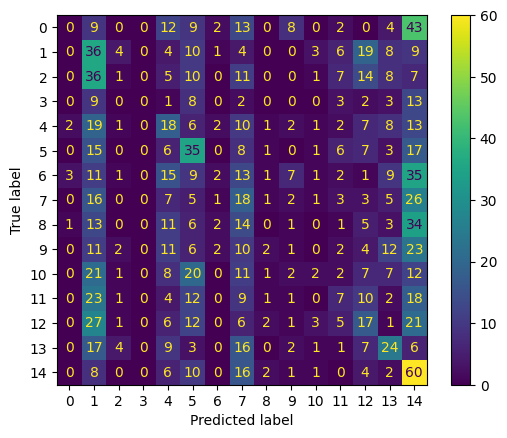

In [42]:
# confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [43]:
# precision, recall, f1-score

from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=label_to_int.keys()))


                                 precision    recall  f1-score   support

            2-onder-1-kapwoning       0.00      0.00      0.00       102
                  Benedenwoning       0.13      0.35      0.19       104
                    Bovenwoning       0.06      0.01      0.02       100
                   Corridorflat       0.00      0.00      0.00        41
                     Eindwoning       0.15      0.20      0.17        92
                    Galerijflat       0.22      0.35      0.27        99
Geschakelde 2-onder-1-kapwoning       0.17      0.02      0.03       110
             Geschakelde woning       0.11      0.20      0.14        88
         Halfvrijstaande woning       0.00      0.00      0.00        91
                     Hoekwoning       0.04      0.01      0.02        86
                    Maisonnette       0.13      0.02      0.04        94
                    Portiekflat       0.14      0.08      0.10        88
                  Portiekwoning       0.16      0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [8]:
print(df['woningtype'].value_counts())


woningtype
Corridorflat                       500
Eindwoning                         493
Hoekwoning                         493
Geschakelde 2-onder-1-kapwoning    492
Portiekflat                        491
Maisonnette                        490
Tussenwoning                       489
Galerijflat                        489
Benedenwoning                      488
Geschakelde woning                 487
2-onder-1-kapwoning                485
Vrijstaande woning                 483
Halfvrijstaande woning             479
Bovenwoning                        473
Portiekwoning                      469
Name: count, dtype: Int64


In [46]:
def top_k_accuracy(output, target, k=3):
    with torch.no_grad():
        _, pred = output.topk(k, 1, True, True)
        correct = pred.eq(target.view(-1, 1).expand_as(pred))
        return correct.sum().item() / target.size(0)

# Example in evaluation loop
total_top3 = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = net(inputs)
        total_top3 += top_k_accuracy(outputs, labels, k=3) * labels.size(0)
        total += labels.size(0)

print(f'Top-3 Accuracy: {100 * total_top3 / total:.2f}%')


Top-3 Accuracy: 37.08%
